<a href="https://colab.research.google.com/github/JishnuJayaraj/ML/blob/master/NLP/USE/sentimentAnalysis/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Oct 26 23:24:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install gdown
!pip install tensorflow_text

     |████████████████████████████████| 2.6MB 2.8MB/s 


In [ ]:
!pip install wordcloud

In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 44kB/s 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
!gdown --id 1e1SsVct7B6m3GLKlYKHb4ZGy8Ws4K35r --output 515k-hotel-reviews-data-in-europe.zip

Downloading...
From: https://drive.google.com/uc?id=1e1SsVct7B6m3GLKlYKHb4ZGy8Ws4K35r
To: /content/515k-hotel-reviews-data-in-europe.zip
47.3MB [00:01, 32.2MB/s]


In [ ]:
!unzip -q 515k-hotel-reviews-data-in-europe.zip

In [ ]:
!ls

515k-hotel-reviews-data-in-europe.zip  Hotel_Reviews.csv  sample_data


In [ ]:
df = pd.read_csv("Hotel_Reviews.csv", parse_dates=['Review_Date'])
df.shape

(515738, 17)

# Exploration

In [ ]:
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-24,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [ ]:
df["review"] = df["Negative_Review"] + df["Positive_Review"]
df["review_type"] = df["Reviewer_Score"].apply(
  lambda x: "bad" if x < 7 else "good"
)

In [ ]:
df = df[["review", "review_type"]]

In [ ]:
df.review_type.value_counts()

good    428887
bad      86851
Name: review_type, dtype: int64

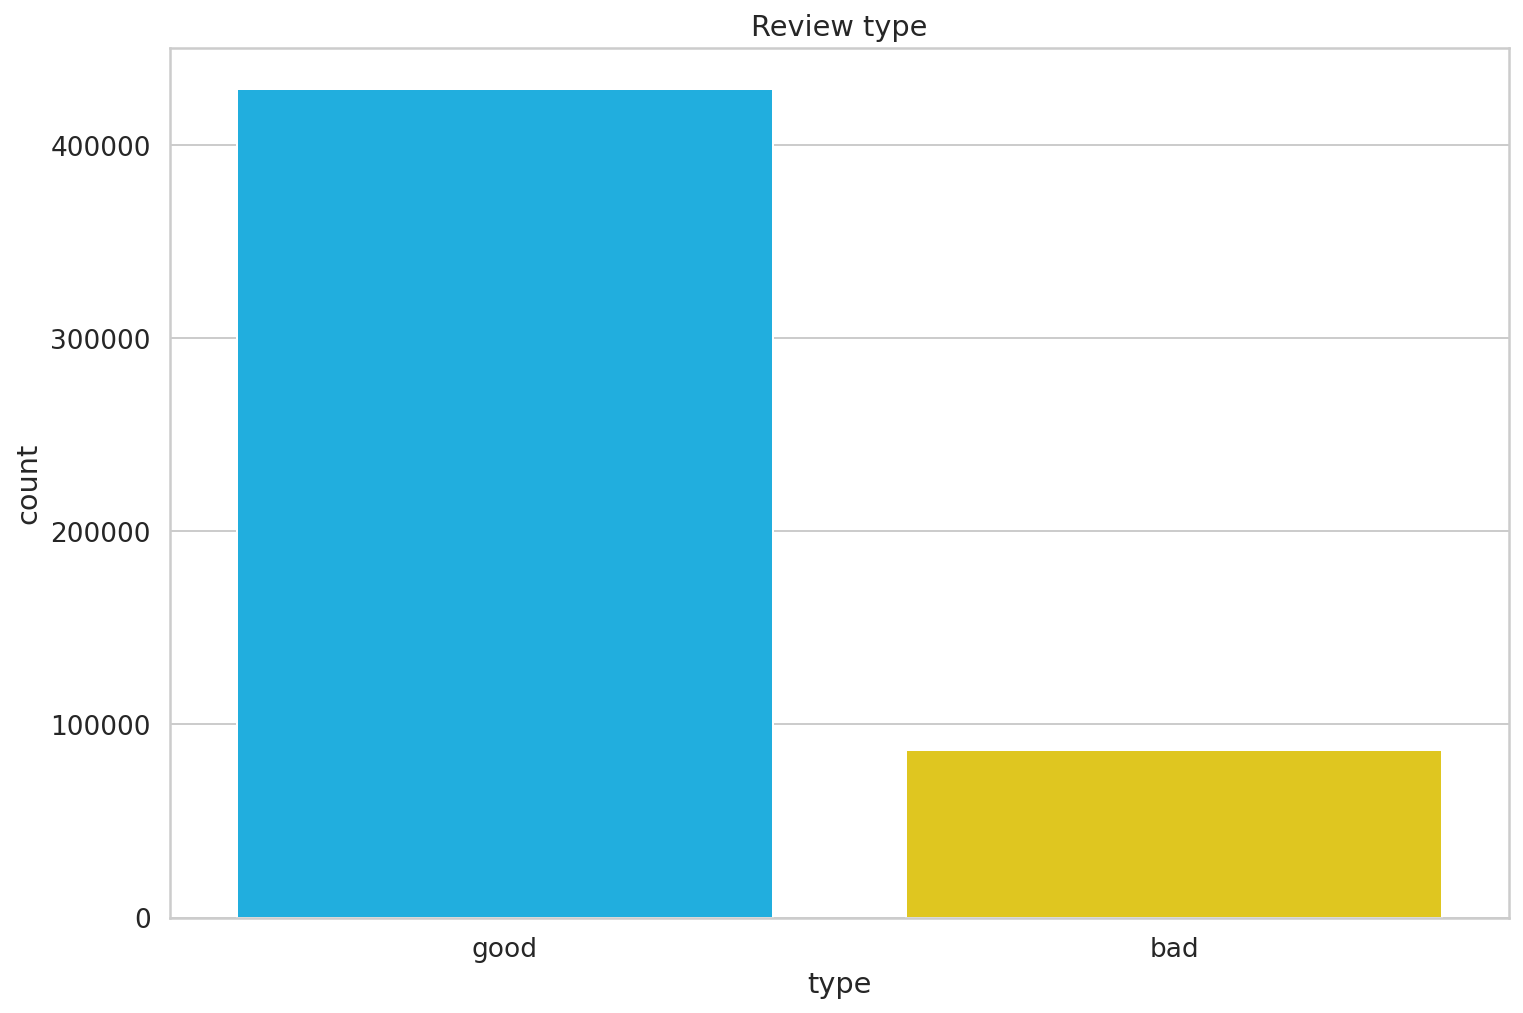

In [ ]:
sns.countplot(
  x='review_type',
  data=df,
  order=df.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type");

In [ ]:
good_reviews = df[df.review_type == "good"]
bad_reviews = df[df.review_type == "bad"]

In [ ]:
print(good_reviews.shape, bad_reviews.shape)

(428887, 2) (86851, 2)


In [ ]:
good_reviews_text = " ".join(good_reviews.review.to_numpy().tolist())
bad_reviews_text = " ".join(bad_reviews.review.to_numpy().tolist())

good_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(good_reviews_text)
bad_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(bad_reviews_text)

In [ ]:
def show_word_cloud(cloud, title):
  plt.figure(figsize = (16, 10))
  plt.imshow(cloud, interpolation='bilinear')
  plt.title(title)
  plt.axis("off")
  plt.show();

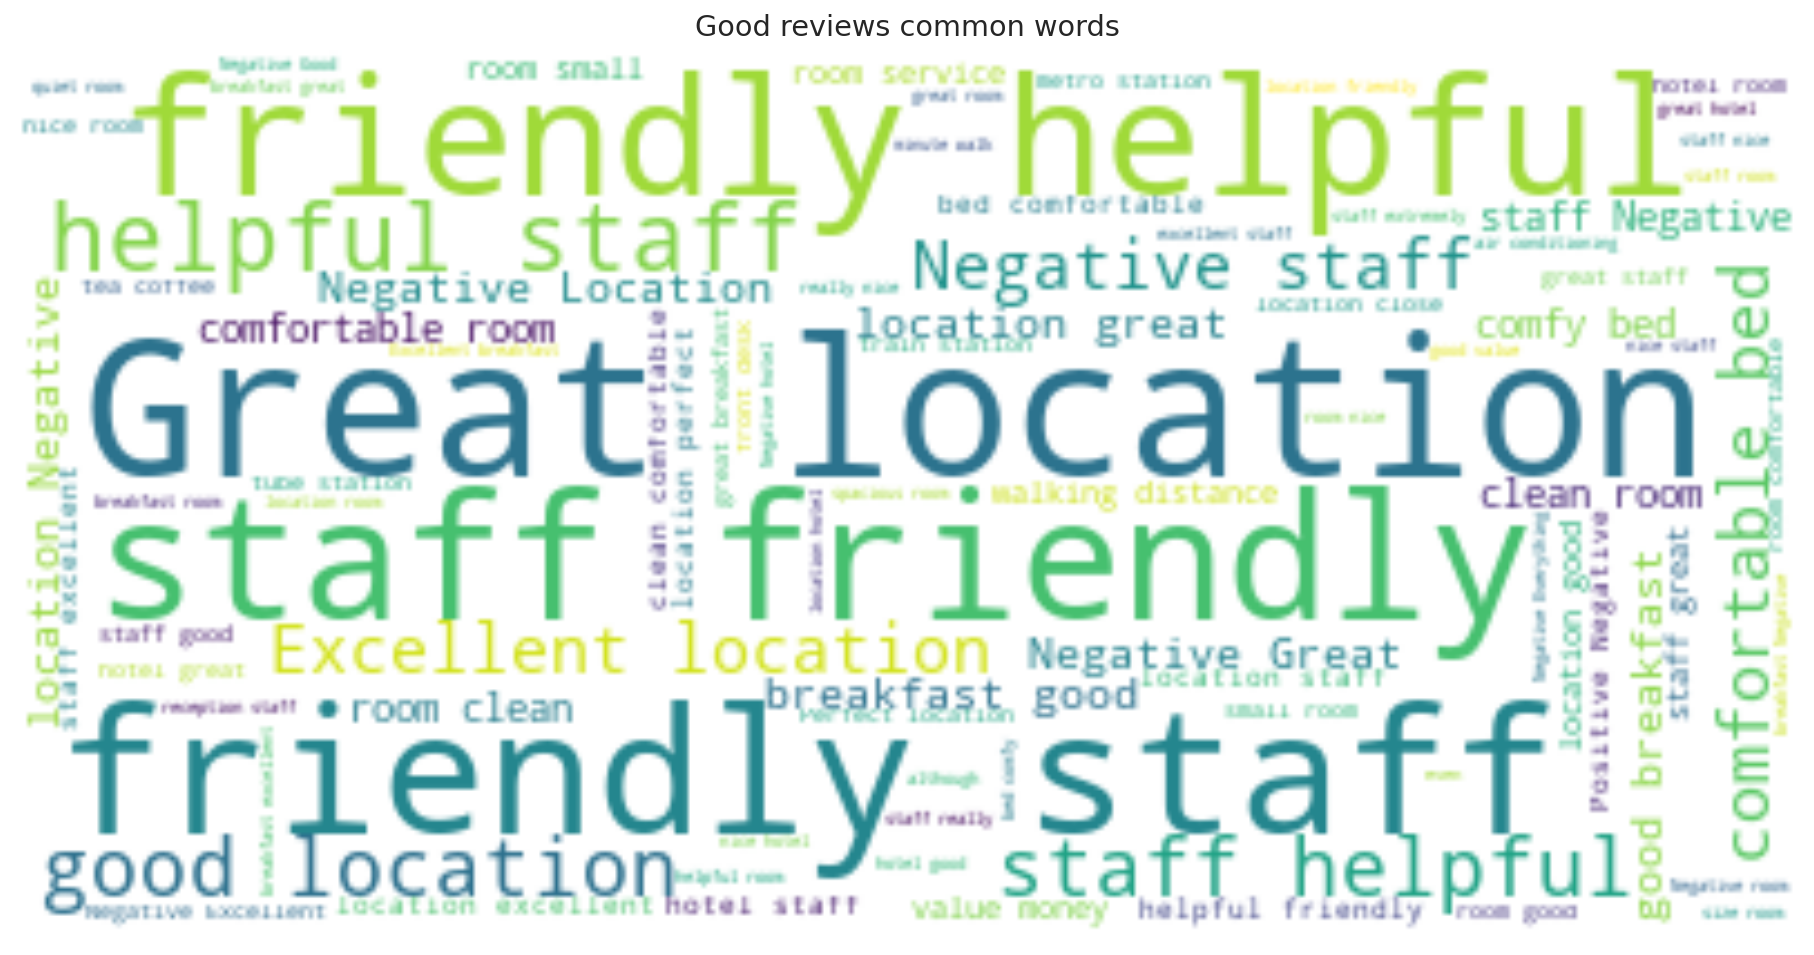

In [ ]:
show_word_cloud(good_reviews_cloud, "Good reviews common words")

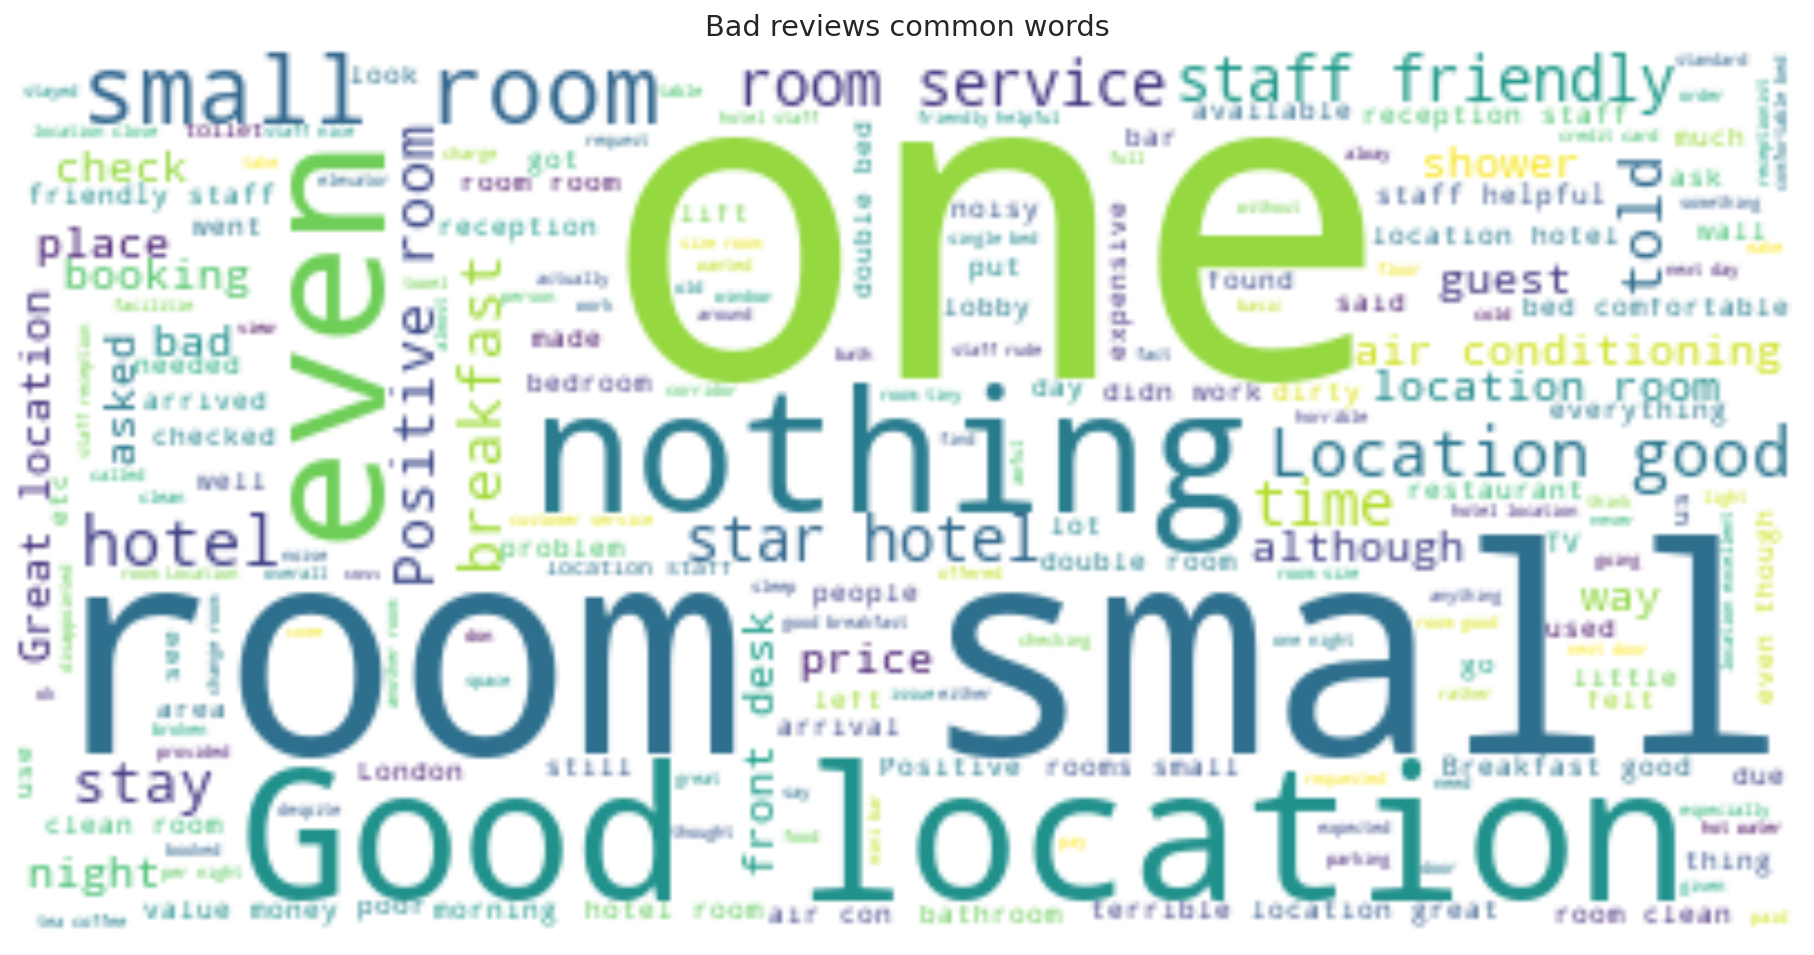

In [ ]:
show_word_cloud(bad_reviews_cloud, "Bad reviews common words")

In [ ]:
good_df = good_reviews.sample(n=len(bad_reviews), random_state=RANDOM_SEED)
bad_df = bad_reviews

In [ ]:
review_df = good_df.append(bad_df).reset_index(drop=True)
review_df.shape

(173702, 2)

In [ ]:
review_df.head()

,review,review_type
0,Nothing not to like Location was excellent r...,good
1,Replenishment of supplies in room toiletries ...,good
2,No Negative The views,good
3,Could do with biscuits and a complimentary wa...,good
4,Bar prices expensive and mini bar very expens...,good


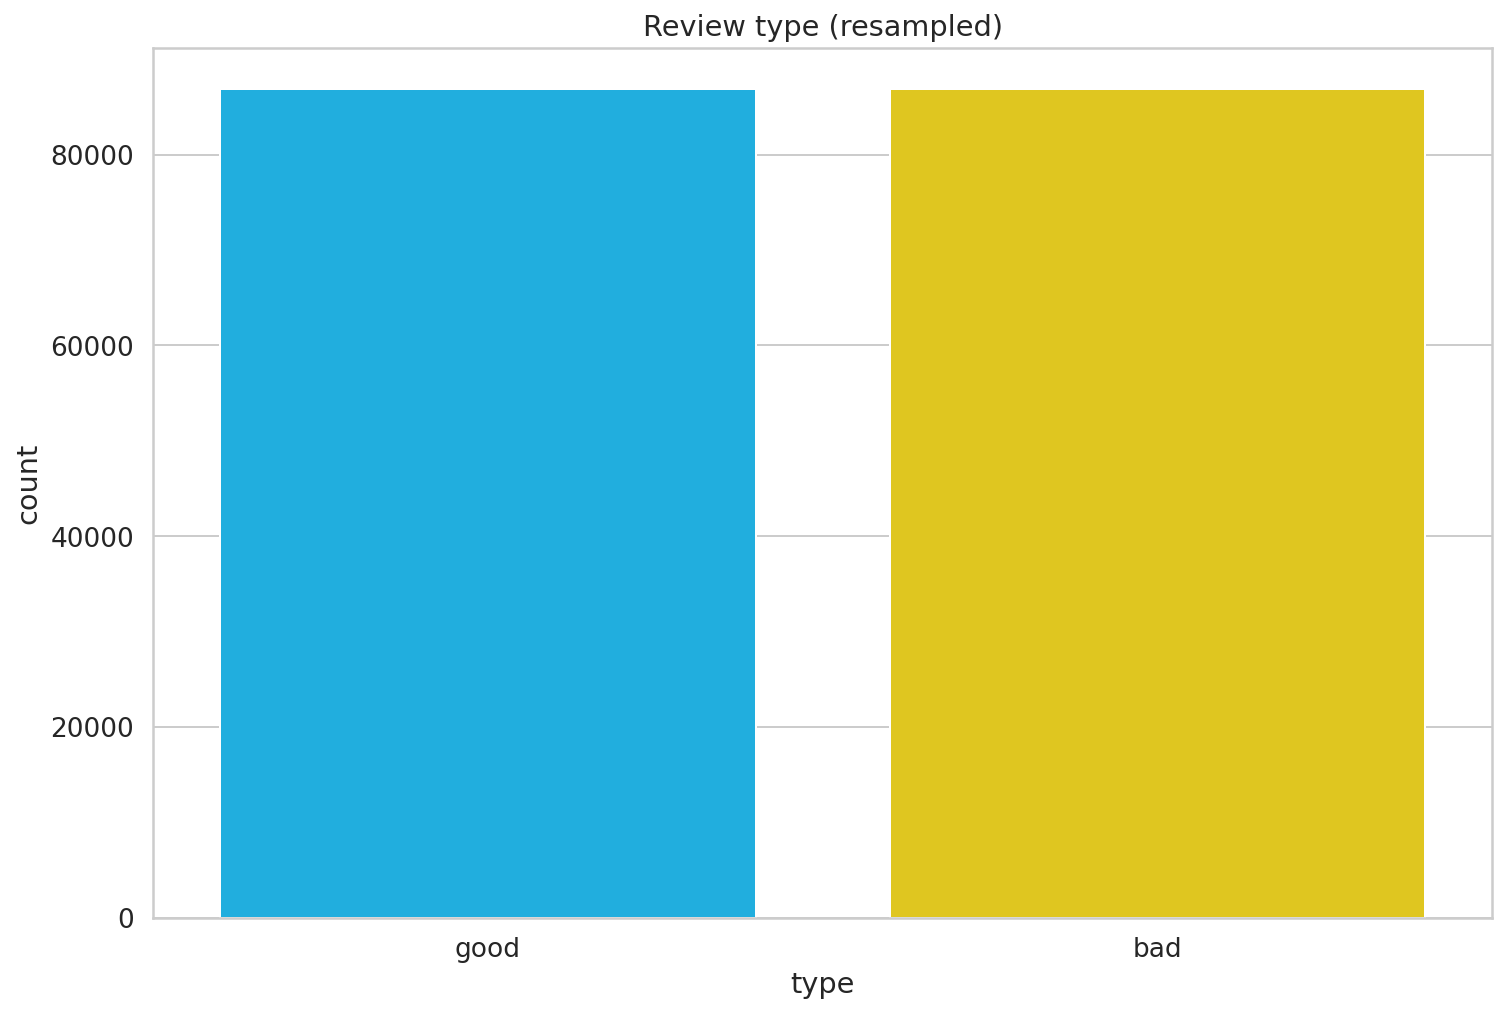

In [ ]:
sns.countplot(
  x='review_type',
  data=review_df,
  order=review_df.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type (resampled)");

# Universal Sentence Encoder

In [ ]:
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [ ]:
sent_1 = ["the location is great"]
sent_2 = ["amazing location"]

emb_1 = use(sent_1)
emb_2 = use(sent_2)

In [ ]:
emb_1.shape

TensorShape([1, 512])

In [ ]:
np.inner(emb_1, emb_2).flatten()[0]

0.79254687

# Preprocessing

In [ ]:
from sklearn.preprocessing import OneHotEncoder

type_one_hot = OneHotEncoder(sparse=False).fit_transform(
  review_df.review_type.to_numpy().reshape(-1, 1)
)

In [ ]:
train_reviews, test_reviews, y_train, y_test =\
  train_test_split(
    review_df.review, 
    type_one_hot, 
    test_size=.1, 
    random_state=RANDOM_SEED
  )

In [ ]:
X_train = []
for r in tqdm(train_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(review_emb)

X_train = np.array(X_train)

100%|██████████| 156331/156331 [40:15<00:00, 64.72it/s]


In [ ]:
X_test = []
for r in tqdm(test_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 17371/17371 [04:25<00:00, 65.39it/s]


In [ ]:
print(X_train.shape, X_test.shape)

(156331, 512) (17371, 512)


In [ ]:
print(X_train.shape, y_train.shape)

(156331, 512) (156331, 2)


# Sentiment Analysis

In [ ]:
model = keras.Sequential()

model.add(
  keras.layers.Dense(
    units=256,
    input_shape=(X_train.shape[1], ),
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)

model.add(
  keras.layers.Dense(
    units=128,
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)

model.add(keras.layers.Dense(2, activation='softmax'))
model.compile(
    loss='categorical_crossentropy', 
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
8794/8794 [==============================] - 24s 3ms/step - loss: 0.4343 - accuracy: 0.7976 - val_loss: 0.4022 - val_accuracy: 0.8110
Epoch 2/10
8794/8794 [==============================] - 24s 3ms/step - loss: 0.4124 - accuracy: 0.8101 - val_loss: 0.3926 - val_accuracy: 0.8173
Epoch 3/10
8794/8794 [==============================] - 24s 3ms/step - loss: 0.4034 - accuracy: 0.8155 - val_loss: 0.3914 - val_accuracy: 0.8164
Epoch 4/10
8794/8794 [==============================] - 24s 3ms/step - loss: 0.3969 - accuracy: 0.8197 - val_loss: 0.3876 - val_accuracy: 0.8217
Epoch 5/10
8794/8794 [==============================] - 24s 3ms/step - loss: 0.3911 - accuracy: 0.8220 - val_loss: 0.3899 - val_accuracy: 0.8202
Epoch 6/10
8794/8794 [==============================] - 23s 3ms/step - loss: 0.3862 - accuracy: 0.8258 - val_loss: 0.3844 - val_accuracy: 0.8224
Epoch 7/10
8794/8794 [==============================] - 24s 3ms/step - loss: 0.3809 - accuracy: 0.8285 - val_loss: 0.3822 - val_ac

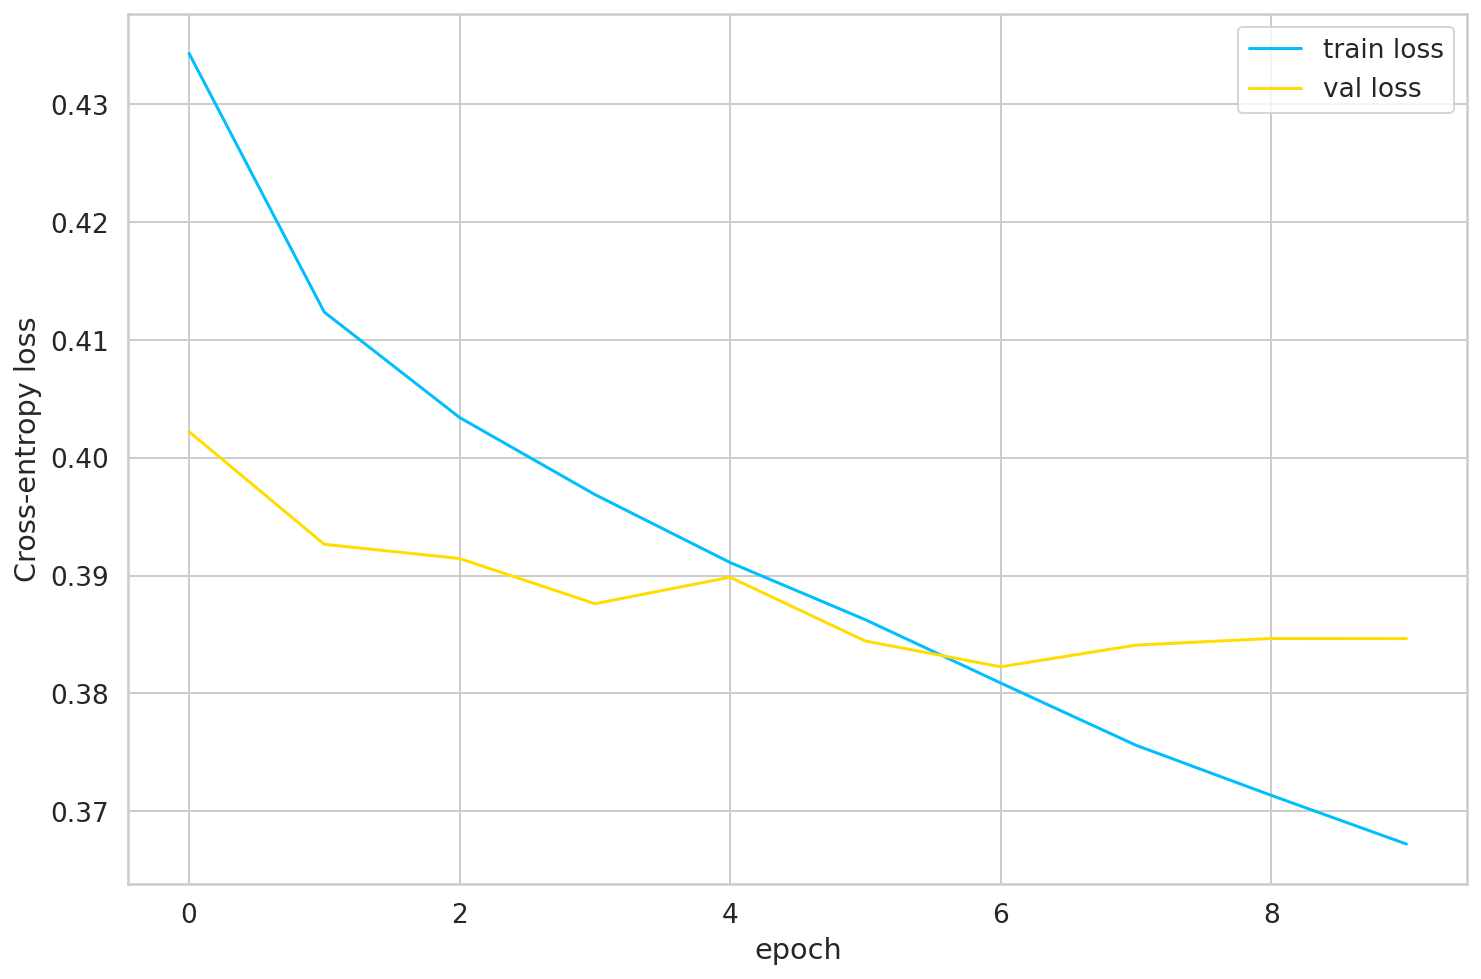

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();

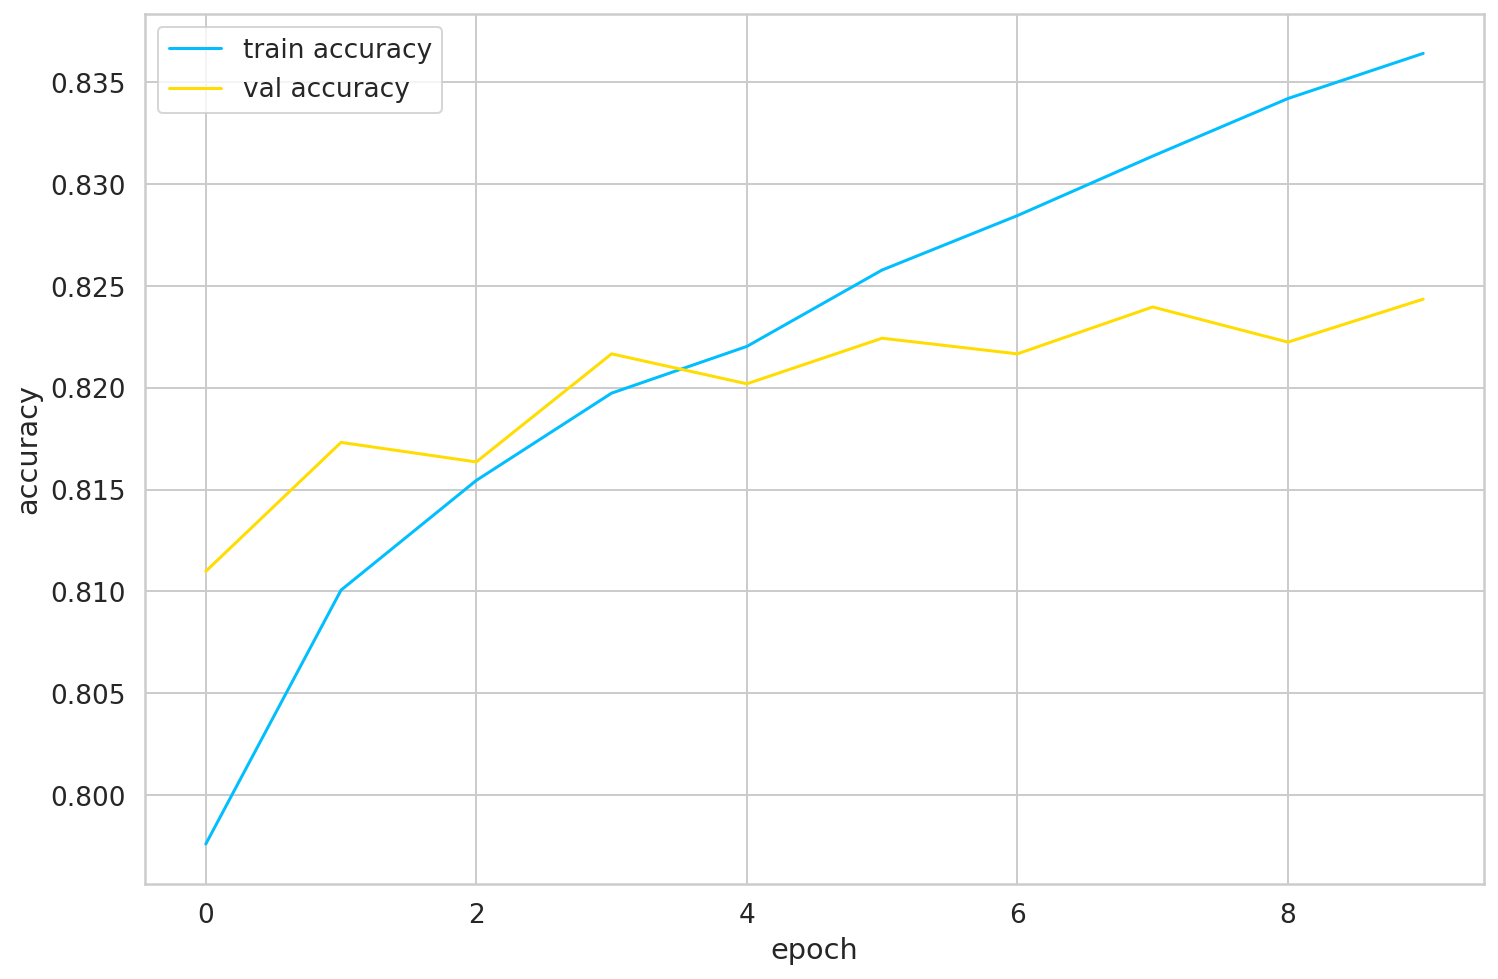

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [ ]:
model.evaluate(X_test, y_test)

543/543 [==============================] - 1s 2ms/step - loss: 0.3968 - accuracy: 0.8184


[0.3967597782611847, 0.8183754682540894]

# Predictions

In [ ]:
print(test_reviews.iloc[0])
print("Bad" if y_test[0][0] == 1 else "Good")

 Asked for late checkout and didnt get an answer then got a yes but had to pay 25 euros by noon they called to say sorry you have to leave in 1h knowing that i had a sick dog and an appointment next to the hotel  Location staff 
Bad


In [ ]:
y_pred = model.predict(X_test[:1])
print(y_pred)
"Bad" if np.argmax(y_pred) == 0 else "Good"

[[0.8691949  0.13080506]]


'Bad'

In [ ]:
print(test_reviews.iloc[1])
print("Bad" if y_test[1][0] == 1 else "Good")

 Don t really like modern hotels Had no character Bed was too hard  Good location rooftop pool new hotel nice balcony nice breakfast 
Good


In [ ]:
y_pred = model.predict(X_test[1:2])
print(y_pred)
"Bad" if np.argmax(y_pred) == 0 else "Good"

[[0.4749603 0.5250397]]


'Good'

In [ ]:
print(test_reviews.iloc[5])
print("Bad" if y_test[5][0] == 1 else "Good")

 Flooded bathroom from room above Painting and decorating blocking stair access  Easy to find Easy location No traffic noise in room 
Bad


In [ ]:
y_pred = model.predict(X_test[5:6])
print(y_pred)
"Bad" if np.argmax(y_pred) == 0 else "Good"

[[0.75533164 0.2446684 ]]


'Bad'